In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Dataset/temprel.csv')


# use LOCF algorithm to fill missing stock prices
df.fillna(method='ffill', inplace=True)


In [3]:
df.head()

,timestamp,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient
0,10-02-2023,2357.0000,2357.0000,2321.6001,2336.3501,2336.3501,127318,0.0,1.0
1,09-02-2023,2357.3501,2370.8000,2334.0500,2355.3999,2355.3999,88852,0.0,1.0
2,08-02-2023,2311.3000,2359.6001,2307.1499,2351.8000,2351.8000,268850,0.0,1.0
3,07-02-2023,2312.0000,2327.0000,2293.1001,2351.8000,2305.8999,225094,0.0,1.0
4,06-02-2023,2325.0000,2325.0000,2306.7500,2311.5000,2311.5000,206263,0.0,1.0


In [4]:
# Create a new dataframe with only the 'Close' column 
data = df.filter(['close'])
# Convert the dataframe to a numpy array
dataset = data.values

# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .6 ))

window_size = 60
training_data_len

2679

In [5]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# create scaler
scaler = StandardScaler()
# fit and transform in one step
scaled_data = scaler.fit_transform(dataset)

print ('scaled_data.shape',len(scaled_data))
scaled_data

scaled_data.shape 4464


array([[ 1.64141865],
       [ 1.67232941],
       [ 1.66648811],
       ...,
       [-1.50683618],
       [-1.50574431],
       [-1.49082439]])

In [6]:
# Create the training data set 
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len)]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(window_size, len(train_data)):
    x_train.append(train_data[i-window_size:i, 0])
    y_train.append(train_data[i, 0])
    if i<= window_size + 1:
        print('x_train',x_train)
        print('\ny_train',y_train)
        print()
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
print ('x_train.shape:',x_train.shape)

x_train [array([1.64141865, 1.67232941, 1.66648811, 1.66648811, 1.60109615,
       1.62957329, 1.62592238, 1.64417696, 1.64417696, 1.66567679,
       1.64369017, 1.71703301, 1.76928151, 1.79272883, 1.81398511,
       1.86006794, 1.86574714, 1.87215637, 1.81723037, 1.81723037,
       1.86169057, 1.94833881, 2.00099313, 2.06362662, 1.96740471,
       1.92886726, 1.93641232, 1.99945163, 2.02890219, 1.9851725 ,
       1.97600464, 1.97908764, 1.98006121, 1.94671618, 1.90947684,
       2.03336442, 2.04391151, 2.10354314, 2.10354314, 2.01259509,
       2.03474382, 2.09340171, 2.10849232, 2.10849232, 2.08399078,
       2.14954484, 2.15019373, 2.21242172, 2.20365969, 2.26824001,
       2.26872696, 2.28406064, 2.24941767, 2.24454978, 2.09689052,
       2.04090981, 1.99855919, 2.01129683, 2.01129683, 2.06524925])]

y_train [2.071334109325117]

x_train [array([1.64141865, 1.67232941, 1.66648811, 1.66648811, 1.60109615,
       1.62957329, 1.62592238, 1.64417696, 1.64417696, 1.66567679,
       1.643

In [7]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
import tensorflow as tf

def build_LSTM_model():
    input = tf.keras.layers.Input(
        shape=(x_train.shape[1], 1), name ="input"
    )
    x = tf.keras.layers.LSTM(128, return_sequences=True)(input)
    
    x = tf.keras.layers.LSTM(64, return_sequences=False, dropout=0.5)(x)
    
    x = tf.keras.layers.Dense(25 , activation="relu", name ="dense_1")(x)
    
    output = tf.keras.layers.Dense(1, name="last_dense")(x)
               
    model = tf.keras.Model(inputs=input, outputs=output)
    
    return model

LSTM_model = build_LSTM_model()
LSTM_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 60, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 60, 128)           66560     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 25)                1625      
                                                                 
 last_dense (Dense)          (None, 1)                 26        
                                                                 
Total params: 117,619
Trainable params: 117,619
Non-trainable params: 0
_________________________________________________________________


In [8]:
epochs = 50
batch_size = 500
early_stopping_patience = 17


# Compile the model
LSTM_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = LSTM_model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs)

Epoch 1/50
6/6 [==============================] - 10s 26ms/step - loss: 0.4993
Epoch 2/50
6/6 [==============================] - 0s 20ms/step - loss: 0.0877
Epoch 3/50
6/6 [==============================] - 0s 18ms/step - loss: 0.0426
Epoch 4/50
6/6 [==============================] - 0s 15ms/step - loss: 0.0367
Epoch 5/50
6/6 [==============================] - 0s 15ms/step - loss: 0.0293
Epoch 6/50
6/6 [==============================] - 0s 16ms/step - loss: 0.0214
Epoch 7/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0185
Epoch 8/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0163
Epoch 9/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0145
Epoch 10/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0129
Epoch 11/50
6/6 [==============================] - 0s 16ms/step - loss: 0.0126
Epoch 12/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0120
Epoch 13/50
6/6 [==============================] - 0s 15ms/s

dict_keys(['loss'])


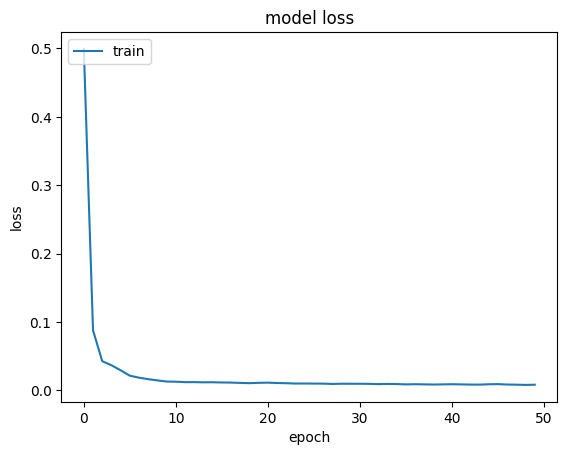

In [9]:
# list all data in history
print(history.history.keys())

# summarize history for loss

fig, ax = plt.subplots()
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [10]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002 
test_data = scaled_data[training_data_len - window_size: ]
print ('len(test_data):', len(test_data))

# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(window_size, len(test_data)):
    x_test.append(test_data[i-window_size:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = LSTM_model.predict(x_test)
predictions = scaler.inverse_transform(predictions)


len(test_data): 1845
56/56 [==============================] - 1s 5ms/step


<ipython-input-11-6511bb59e7ba>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = predictions


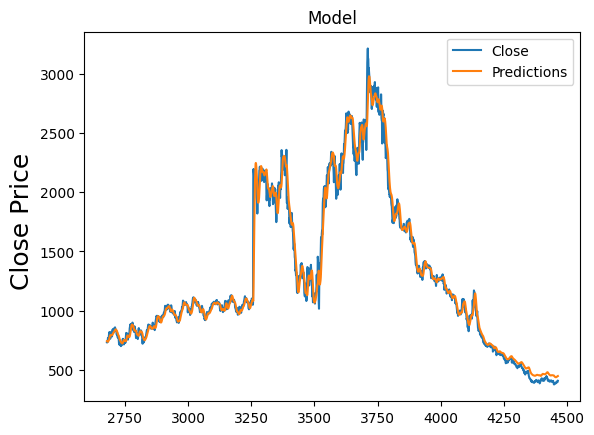

In [11]:
# Plot the data
train = data[:training_data_len]
test = data[training_data_len:]
test['Predictions'] = predictions

# Visualize the data
plt.figure()
plt.title('Model')
plt.ylabel('Close Price ', fontsize=18)
#plt.plot(train['Close'])
plt.plot(test[['close', 'Predictions']])
plt.legend(['Close', 'Predictions'], loc='upper right')
plt.show()

In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
mae = mean_absolute_error(test['Predictions'],y_test)
mse = mean_squared_error(test['Predictions'], y_test)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(test['Predictions'],y_test)
r = r2_score(test['Predictions'], y_test)

In [13]:
print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('Mean Absolute Percentage Error:', mape)
print('R-Squared Score = {}'.format(r))

Mean Absolute Error: 49.50700942801339
Mean Squared Error: 6848.17588547968
Root Mean Squared Error: 82.75370617367949
Mean Absolute Percentage Error: 0.040254535628480394
R-Squared Score = 0.9835627986167419
